# Code Execution

In this section we explore creating custom agents to handle code generation and execution. These tasks can be handled using the provided Agent implementations found here {py:meth}`~autogen_agentchat.agents.AssistantAgent`, {py:meth}`~autogen_agentchat.agents.CodeExecutorAgent`; but this guide will show you how to implement custom, lightweight agents that can replace their functionality. This simple example implements two agents that create a plot of Tesla's and Nvidia's stock returns.

We first define the agent classes and their respective procedures for 
handling messages.
We create two agent classes: `Assistant` and `Executor`. The `Assistant`
agent writes code and the `Executor` agent executes the code.
We also create a `Message` data class, which defines the messages that are passed between
the agents.

```{attention}
Code generated in this example is run within a [Docker](https://www.docker.com/) container. Please ensure Docker is [installed](https://docs.docker.com/get-started/get-docker/) and running prior to running the example. Local code execution is available ({py:class}`~autogen_ext.code_executors.local.LocalCommandLineCodeExecutor`) but is not recommended due to the risk of running LLM generated code in your local environment.
```

In [1]:
import re
from dataclasses import dataclass
from typing import List

from autogen_core import DefaultTopicId, MessageContext, RoutedAgent, default_subscription, message_handler
from autogen_core.code_executor import CodeBlock, CodeExecutor
from autogen_core.models import (
    AssistantMessage,
    ChatCompletionClient,
    LLMMessage,
    SystemMessage,
    UserMessage,
)


@dataclass
class Message:
    content: str


@default_subscription
class Assistant(RoutedAgent):
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("An assistant agent.")
        self._model_client = model_client
        self._chat_history: List[LLMMessage] = [
            SystemMessage(
                content="""Write Python script in markdown block, and it will be executed.
Always save figures to file in the current directory. Do not use plt.show(). All code required to complete this task must be contained within a single response.""",
            )
        ]

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        self._chat_history.append(UserMessage(content=message.content, source="user"))
        result = await self._model_client.create(self._chat_history)
        print(f"\n{'-'*80}\nAssistant:\n{result.content}")
        self._chat_history.append(AssistantMessage(content=result.content, source="assistant"))  # type: ignore
        await self.publish_message(Message(content=result.content), DefaultTopicId())  # type: ignore


def extract_markdown_code_blocks(markdown_text: str) -> List[CodeBlock]:
    pattern = re.compile(r"```(?:\s*([\w\+\-]+))?\n([\s\S]*?)```")
    matches = pattern.findall(markdown_text)
    code_blocks: List[CodeBlock] = []
    for match in matches:
        language = match[0].strip() if match[0] else ""
        code_content = match[1]
        code_blocks.append(CodeBlock(code=code_content, language=language))
    return code_blocks


@default_subscription
class Executor(RoutedAgent):
    def __init__(self, code_executor: CodeExecutor) -> None:
        super().__init__("An executor agent.")
        self._code_executor = code_executor

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        code_blocks = extract_markdown_code_blocks(message.content)
        if code_blocks:
            result = await self._code_executor.execute_code_blocks(
                code_blocks, cancellation_token=ctx.cancellation_token
            )
            print(f"\n{'-'*80}\nExecutor:\n{result.output}")
            await self.publish_message(Message(content=result.output), DefaultTopicId())

You might have already noticed, the agents' logic, whether it is using model or code executor,
is completely decoupled from
how messages are delivered. This is the core idea: the framework provides
a communication infrastructure, and the agents are responsible for their own
logic. We call the communication infrastructure an **Agent Runtime**.

Agent runtime is a key concept of this framework. Besides delivering messages,
it also manages agents' lifecycle. 
So the creation of agents are handled by the runtime.

The following code shows how to register and run the agents using 
{py:class}`~autogen_core.SingleThreadedAgentRuntime`,
a local embedded agent runtime implementation.


In [2]:
import tempfile

from autogen_core import SingleThreadedAgentRuntime
from autogen_ext.code_executors.docker import DockerCommandLineCodeExecutor
from autogen_ext.models.openai import OpenAIChatCompletionClient

work_dir = tempfile.mkdtemp()

# Create an local embedded runtime.
runtime = SingleThreadedAgentRuntime()

async with DockerCommandLineCodeExecutor(work_dir=work_dir) as executor:  # type: ignore[syntax]
    # Register the assistant and executor agents by providing
    # their agent types, the factory functions for creating instance and subscriptions.
    model_client = OpenAIChatCompletionClient(
        model="gpt-4o",
        # api_key="YOUR_API_KEY"
    )
    await Assistant.register(
        runtime,
        "assistant",
        lambda: Assistant(model_client=model_client),
    )
    await Executor.register(runtime, "executor", lambda: Executor(executor))

    # Start the runtime and publish a message to the assistant.
    runtime.start()
    await runtime.publish_message(
        Message("Create a plot of NVIDA vs TSLA stock returns YTD from 2024-01-01."), DefaultTopicId()
    )

    # Wait for the runtime to stop when idle.
    await runtime.stop_when_idle()
    # Close the connection to the model client.
    await model_client.close()


--------------------------------------------------------------------------------
Assistant:
```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Define the ticker symbols for NVIDIA and Tesla
tickers = ['NVDA', 'TSLA']

# Download the stock data from Yahoo Finance starting from 2024-01-01
start_date = '2024-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')

# Download the adjusted closing prices
stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate the daily returns
returns = stock_data.pct_change().dropna()

# Plot the cumulative returns for each stock
cumulative_returns = (1 + returns).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns.index, cumulative_returns['NVDA'], label='NVIDIA', color='green')
plt.plot(cumulative_returns.index, cumulative_returns['TSLA'], label='Tesla', color='red')
plt.title('NVIDIA vs Tesla Stock Returns YTD (2024)')
plt.xlabel('Date')
plt

From the agent's output, we can see the plot of Tesla's and Nvidia's stock returns
has been created.

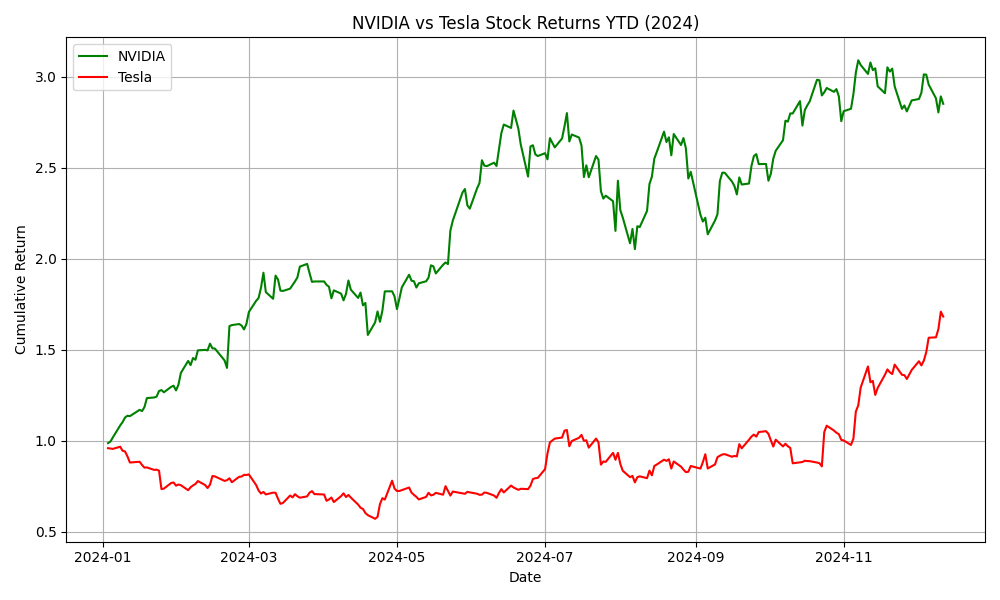

In [3]:
from IPython.display import Image

Image(filename=f"{work_dir}/nvidia_vs_tesla_ytd_returns.png")  # type: ignore

AutoGen also supports a distributed agent runtime, which can host agents running on
different processes or machines, with different identities, languages and dependencies.

To learn how to use agent runtime, communication, message handling, and subscription, please continue
reading the sections following this quick start.